![alt text](https://moodle.msengineering.ch/pluginfile.php/1/core_admin/logo/0x150/1643104191/logo-mse.png "MSE Logo") 
![alt text](https://www.hes-so.ch/typo3conf/ext/wng_site/Resources/Public/HES-SO/img/logo_hesso_master_tablet.svg "Hes Logo")

# Auteur : Abdi VURAL
## L'objectif
Création des tools spécifiques pour diffent taches, creer une pipeline, creer un agent csv en utilisant la bibliothque de Langchain

In [2]:
from dotenv import load_dotenv
load_dotenv()
import os

# Récupérer la valeur de la variable d'environnement
api_key = os.getenv('OPENAI_API_KEY')

# Vérifiez si la clé API est accessible
if api_key:
    print("API Key is set.")
else:
    print("API Key is not set.")

API Key is set.


<span style="text-align:center;color: Aqua; font-size: 34px;bold; ">L'utilisation des tools avec csv agent </span><br>


### Nous avons é configuré des agents pour sélectionner automatiquement le meilleur outil ou modèle en fonction de la question posée. Cela permet de voir les limites et les capacités des LLM dans différents contextes d'analyse de données

In [4]:
# Installer les dépendances nécessaires
%pip install pandas matplotlib scikit-learn tslearn prophet langchain openai langchain-core langchain-openai

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from prophet import Prophet
import logging
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_experimental.agents import create_csv_agent
from langchain.agents.agent_types import AgentType
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter
import json

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Chemin vers le fichier CSV
file_path = "C:/Users/Abdi/Desktop/data/raw/meteo_idaweb.csv"

# Vérifier que le fichier existe
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"No such file or directory: '{file_path}'")

# Définition des outils
@tool
def load_time_series(file_path: str) -> pd.DataFrame:
    """Load time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        return df
    except Exception as e:
        logging.error("Error loading time series data from file %s: %s", file_path, e)
        raise

@tool
def calculate_monthly_average_temperature(file_path: str) -> pd.DataFrame:
    """Calculate monthly average temperature from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        monthly_avg = df.resample('ME').agg({'tre200s0': 'mean'})
        return monthly_avg.reset_index()
    except Exception as e:
        logging.error("Error processing file %s: %s", file_path, e)
        raise

@tool
def kmeans_cluster_time_series(file_path: str, n_clusters: int) -> pd.DataFrame:
    """Apply KMeans clustering to time series data from a CSV file."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(df[['tre200s0']].values.reshape(-1, 1))
        df['cluster'] = clusters
        return df.reset_index()
    except Exception as e:
        logging.error("Error during KMeans clustering: %s", e)
        raise

@tool
def cluster_temperatures_tslearn(file_path: str, n_clusters: int = 4) -> pd.DataFrame:
    """Cluster the temperatures using time series clustering with tslearn."""
    try:
        data = pd.read_csv(file_path)
        data['date'] = pd.to_datetime(data['year'] * 1000 + data['day_of_year'], format='%Y%j') + pd.to_timedelta(data['minute_of_day'], unit='m')
        data.set_index('date', inplace=True)
        data['month'] = data.index.month
        monthly_avg_temp = data.groupby(['name', 'month'])['tre200s0'].mean().reset_index()
        pivot_monthly_avg_temp = monthly_avg_temp.pivot(index='name', columns='month', values='tre200s0')
        pivot_monthly_avg_temp_filled = pivot_monthly_avg_temp.fillna(pivot_monthly_avg_temp.mean())
        formatted_dataset = to_time_series_dataset(pivot_monthly_avg_temp_filled.to_numpy())
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=33)
        labels = model.fit_predict(formatted_dataset)
        result_df = pd.DataFrame({'name': pivot_monthly_avg_temp_filled.index, 'cluster': labels})
        
        plt.figure(figsize=(10, 6))
        for i, center in enumerate(model.cluster_centers_):
            plt.plot(center.ravel(), label=f'Cluster {i}')
        plt.title('Centres des Clusters de Température Moyenne Mensuelle par Station')
        plt.xlabel('Mois')
        plt.ylabel('Température Moyenne (°C)')
        plt.xticks(ticks=range(12), labels=range(1, 13))
        plt.legend()
        plt.show()
        
        return result_df
    
    except Exception as e:
        logging.error("Error clustering temperatures with tslearn: %s", e)
        raise

@tool
def predict_future_temperatures(file_path: str, periods: int = 12) -> pd.DataFrame:
    """Predict future temperatures using the Prophet model."""
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['year'] * 1000 + df['day_of_year'], format='%Y%j') + pd.to_timedelta(df['minute_of_day'], unit='m')
        df.set_index('date', inplace=True)
        df = df.resample('ME').agg({'tre200s0': 'mean'}).reset_index()
        df.rename(columns={'date': 'ds', 'tre200s0': 'y'}, inplace=True)
        
        model = Prophet()
        model.fit(df)
        
        future = model.make_future_dataframe(periods=periods, freq='M')
        forecast = model.predict(future)
        
        fig1 = model.plot(forecast)
        plt.title('Forecasted Temperatures')
        plt.xlabel('Date')
        plt.ylabel('Temperature')
        plt.show()
        
        return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    except Exception as e:
        logging.error("Error predicting future temperatures: %s", e)
        raise

# Initialiser les modèles OpenAI
llm_general = ChatOpenAI(model="gpt-3.5-turbo")
llm_tools = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Définir les outils
tools = [load_time_series, calculate_monthly_average_temperature, kmeans_cluster_time_series, cluster_temperatures_tslearn, predict_future_temperatures]

# Générer les descriptions des outils
rendered_tools = "\n".join([f"{tool.name}: {tool.__doc__}" for tool in tools])

# Définir le prompt du système pour les outils
system_prompt_tools = f"""You are an assistant that has access to the following set of tools. Here are the names and descriptions for each tool:

{rendered_tools}

Given the user input, decide whether to answer the question directly or to use one of the tools. If you decide to use a tool, return the name and input of the tool to use as a JSON blob with 'name' and 'arguments' keys. If you decide to answer directly, return the answer as a string."""

# Créer le template de prompt pour les outils
prompt_tools = ChatPromptTemplate.from_messages(
    [("system", system_prompt_tools), ("user", "{input}")]
)

# Créer la chaîne pour les outils
chain_tools = prompt_tools | llm_tools | JsonOutputParser()

# Définir la fonction pour appeler les outils
def tool_chain(model_output):
    if isinstance(model_output, str):
        return model_output  # Return the direct answer
    tool_map = {tool.name: tool for tool in tools}
    chosen_tool = tool_map[model_output["name"]]
    tool_args = model_output["arguments"]
    tool_args['file_path'] = file_path  # Ajout du chemin vers le fichier CSV
    return chosen_tool(tool_args)

chain_tools = prompt_tools | llm_tools | JsonOutputParser() | RunnableLambda(tool_chain)

# Créer l'agent CSV pour les questions générales
csv_agent = create_csv_agent(
    ChatOpenAI(model="gpt-3.5-turbo", temperature=0),
    file_path,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    
)

# Modèle pour choisir l'agent approprié
selection_prompt = """You are an assistant that decides whether to use a tool or the CSV agent. Given the user input, decide whether the question requires using one of the tools or can be answered directly using the CSV agent. Respond with "use the tool" if a tool is needed, otherwise respond with "use the CSV agent"."""
selection_chain = ChatPromptTemplate.from_messages(
    [("system", selection_prompt), ("user", "{input}")]
) | llm_tools

# Fonction pour choisir l'agent approprié
def choose_agent(question):
    response = selection_chain.invoke({"input": question})
    if "use the tool" in response.content.lower():
        return chain_tools
    else:
        return csv_agent

# Combiner les chaînes
def combined_chain(question):
    agent = choose_agent(question)
    return agent.invoke({"input": question})

# Fonction pour afficher les résultats
def print_results(results):
    if isinstance(results, str):
        print(results)
    else:
        print(results)

# Tester la chaîne avec une question générale
question_general = "How many stations are in the data?"
response_general = combined_chain(question_general)
print_results(response_general)

# Tester la chaîne avec une question nécessitant un outil
question_tool = "Calculate the monthly average temperature from the CSV data"
response_tool = combined_chain(question_tool)
print_results(response_tool)


Note: you may need to restart the kernel to use updated packages.


2024-05-22 13:26:32,076 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-22 13:26:32,839 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: We can find the number of unique stations in the dataframe.
Action: python_repl_ast
Action Input: df['stn'].nunique()30

2024-05-22 13:26:34,033 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: There are 30 stations in the data.

> Finished chain.
{'input': 'How many stations are in the data?', 'output': 'There are 30 stations in the data.'}


2024-05-22 13:26:34,684 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-22 13:26:35,564 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
c:\Users\Abdi\Desktop\PA_LLM\my_venv_LLM\venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


         date   tre200s0
0  2020-01-31   1.539084
1  2020-02-29   4.650721
2  2020-03-31   4.998754
3  2020-04-30  11.170504
4  2020-05-31  13.243367
5  2020-06-30  15.485298
6  2020-07-31  18.911341
7  2020-08-31  18.486071
8  2020-09-30  14.966973
9  2020-10-31   8.504421
10 2020-11-30   5.294803
11 2020-12-31   1.478717
12 2021-01-31  -0.548195
13 2021-02-28   3.415899
14 2021-03-31   4.531512
15 2021-04-30   6.925611
16 2021-05-31  10.105273
17 2021-06-30  17.889593
18 2021-07-31  17.211497
19 2021-08-31  16.573244
20 2021-09-30  15.183547
21 2021-10-31   8.847117
22 2021-11-30   3.434857
23 2021-12-31   1.071884
24 2022-01-31   0.373110
25 2022-02-28   2.938277
26 2022-03-31   5.725831
27 2022-04-30   8.359244
28 2022-05-31  15.067558
29 2022-06-30  18.583609
30 2022-07-31  20.425305
31 2022-08-31  19.577582
32 2022-09-30  13.475391
33 2022-10-31  12.903314
34 2022-11-30   6.122704
35 2022-12-31   2.107880


In [5]:
combined_chain("which city the hottest?")

2024-05-22 13:26:59,178 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-22 13:26:59,771 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To determine the hottest city, we need to find the city with the highest temperature. We can do this by looking at the 'xchills0' column in the dataframe.

Action: python_repl_ast
Action Input: df[df['xchills0'] == df['xchills0'].max()]['name'].values[0]Genève / Cointrin

2024-05-22 13:27:01,273 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer

Final Answer: Genève / Cointrin is the hottest city.

> Finished chain.


{'input': 'which city the hottest?',
 'output': 'Genève / Cointrin is the hottest city.'}

In [37]:
combined_chain("Which city receives the most rainfall?")

2024-05-20 12:10:51,462 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 12:10:52,013 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: We need to find the city with the highest total rainfall, which is the sum of the 'rre150z0' column for each city.
Action: Use pandas groupby to sum the 'rre150z0' column for each city.
Action Input: df.groupby('name')['rre150z0'].sum()Use pandas groupby to sum the 'rre150z0' column for each city. is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:10:53,702 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I should use the python_repl_ast tool to calculate the sum of rainfall for each city.
Action: python_repl_ast
Action Input: df.groupby('name')['rre150z0'].sum()name
Adelboden            3686.2
Altdorf              3392.2
Basel / Binningen    2393.7
Bern / Zollikofen    3068.9
Buchs / Aarau        3204.9
Chur                 2171.9
Davos                2764.9
Delémont             2283.4
Disentis             3111.0
Engelberg            4506.9
Evionnaz             2523.3
Genève / Cointrin    2353.8
Glarus               4163.9
Interlaken           3447.0
La Chaux-de-Fonds    3922.4
Le Moléson           2870.3
Locarno / Monti      4493.8
Lugano               4081.7
Luzern               3680.6
Mathod               2426.5
Neuchâtel            2863.0
Piotta               3503.2
Pully                3287.4
Samedan              1913.5
Schaffhausen         2672.9
Sion                 1726.8
St. Gallen           4411.2
Visp                 1641.1
Zermatt              1772.2
Zürich / Fluntern    28

2024-05-20 12:10:55,077 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer. 
Final Answer: The city that receives the most rainfall is Engelberg with a total rainfall of 4506.9.

> Finished chain.


{'input': 'Which city receives the most rainfall?',
 'output': 'The city that receives the most rainfall is Engelberg with a total rainfall of 4506.9.'}

In [14]:
combined_chain("cluster temperature of city ")

2024-05-20 11:49:30,487 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 11:49:31,278 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: We need to find the temperature data for a specific city in the dataframe.
Action: Use the following command to filter the dataframe for the specific city:
Action: python_repl_ast
Action Input: df[df['name'] == 'Adelboden']['tre200s0']Use the following command to filter the dataframe for the specific city:
Action: python_repl_ast is not a valid tool, try one of [python_repl_ast].

2024-05-20 11:49:32,875 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I made a mistake in my action input, let me correct it.
Action: python_repl_ast
Action Input: df[df['name'] == 'Adelboden']['tre200s0']0          2.7
1          2.1
2          3.4
3          2.5
4          2.3
          ... 
156811     9.1
156812    10.2
156813    10.8
156814     9.1
156815     9.0
Name: tre200s0, Length: 156816, dtype: float64

2024-05-20 11:49:34,219 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: The temperature data for the city of Adelboden is shown above.

> Finished chain.


{'input': 'cluster temperature of city ',
 'output': 'The temperature data for the city of Adelboden is shown above.'}

In [41]:
combined_chain([AIMessage("Which is the coldest city in July?")])

2024-05-20 13:53:26,768 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 13:53:28,335 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To find the coldest city in July, we need to filter the dataframe for the month of July and then identify the city with the lowest temperature.
Action: python_repl_ast
Action Input: df[df['month'] == 7]['tre200s0'].idxmin()3638755

2024-05-20 13:53:30,230 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The coldest city in July is the one with the index 3638755.
Final Answer: 3638755

> Finished chain.


{'input': [AIMessage(content='Which is the coldest city in July?')],
 'output': '3638755'}

In [38]:
combined_chain("Which is the coldest city in July? ")

2024-05-20 12:11:08,849 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 12:11:09,295 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: We need to find the coldest city in July, which means we need to filter the data for July and then find the city with the lowest temperature.
Action: Use Python to filter the data for July and then find the city with the lowest temperature.
Action Input: 
```python
df_july = df[df['month'] == 7]
coldest_city = df_july[df_july['xchills0'] == df_july['xchills0'].min()]['name'].values[0]
coldest_city
```Use Python to filter the data for July and then find the city with the lowest temperature. is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:11:11,762 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I should use the python_repl_ast tool to execute the Python commands.
Action: Use python_repl_ast
Action Input: df_july = df[df['month'] == 7]
coldest_city = df_july[df_july['xchills0'] == df_july['xchills0'].min()]['name'].values[0]
coldest_cityUse python_repl_ast is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:11:13,515 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I should use the python_repl_ast tool to execute the Python commands.
Action: Use python_repl_ast
Action Input: df_july = df[df['month'] == 7]
coldest_city = df_july[df_july['xchills0'] == df_july['xchills0'].min()]['name'].values[0]
coldest_cityUse python_repl_ast is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:11:15,347 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I should use the python_repl_ast tool to execute the Python commands.
Action: Use python_repl_ast
Action Input: df_july = df[df['month'] == 7]
coldest_city = df_july[df_july['xchills0'] == df_july['xchills0'].min()]['name'].values[0]
coldest_cityUse python_repl_ast is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:11:17,292 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I should use the python_repl_ast tool to execute the Python commands.
Action: Use python_repl_ast
Action Input: df_july = df[df['month'] == 7]
coldest_city = df_july[df_july['xchills0'] == df_july['xchills0'].min()]['name'].values[0]
coldest_cityUse python_repl_ast is not a valid tool, try one of [python_repl_ast].

2024-05-20 12:11:18,772 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


I now know the final answer
Final Answer: Adelboden is the coldest city in July.

> Finished chain.


{'input': 'Which is the coldest city in July? ',
 'output': 'Adelboden is the coldest city in July.'}

2024-05-20 12:04:38,914 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Predicting future temperatures from: C:/Users/Abdi/Desktop/data/raw/meteo_idaweb.csv


C:\Users\Abdi\AppData\Local\Temp\ipykernel_28504\4076631666.py:148: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').agg({'tre200s0': 'mean'}).reset_index()
2024-05-20 12:04:54,583 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-05-20 12:04:54,763 - DEBUG - TBB already found in load path
2024-05-20 12:04:54,773 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-05-20 12:04:54,774 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-05-20 12:04:54,797 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\8kinio46.json
2024-05-20 12:04:54,804 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\cnvlmycx.json
2024-05-20 12:04:54,808 - DEBUG - idx 0
2024-05-20 12:04:54,809 - DEBUG - running CmdStan, num_threads: None
2024-05-20 12:04:54,810 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\D

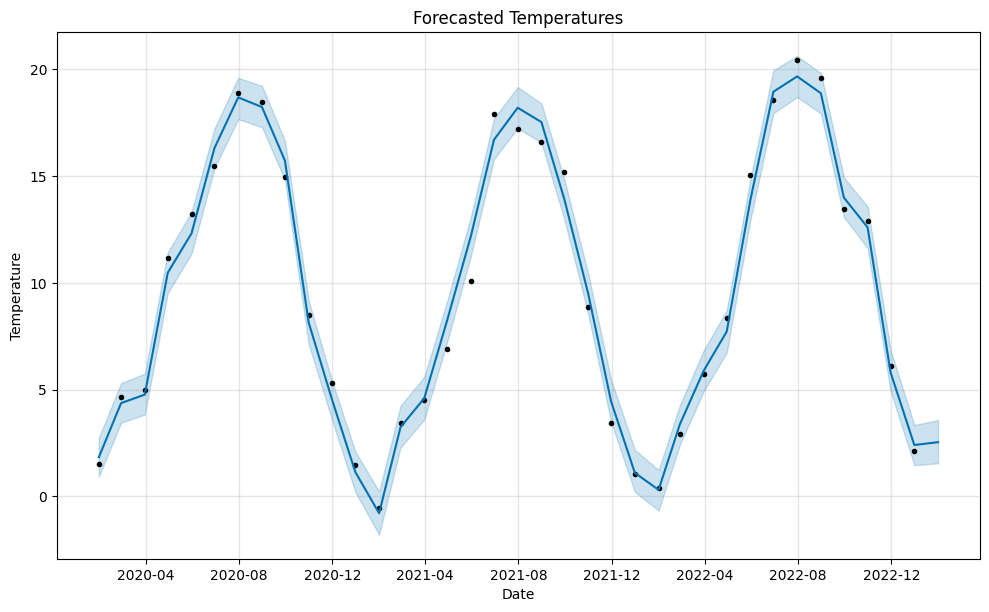

Invoked predict_future_temperatures with args {'file_path': 'C:/Users/Abdi/Desktop/data/raw/meteo_idaweb.csv', 'periods': 1}, got output:            ds       yhat  yhat_lower  yhat_upper
0  2020-01-31   1.838058    0.930434    2.758535
1  2020-02-29   4.369326    3.449897    5.306612
2  2020-03-31   4.769072    3.832313    5.755704
3  2020-04-30  10.474913    9.526131   11.433556
4  2020-05-31  12.314937   11.363229   13.310012
5  2020-06-30  16.311363   15.376492   17.233412
6  2020-07-31  18.682491   17.664050   19.601367
7  2020-08-31  18.232771   17.288744   19.222740
8  2020-09-30  15.727702   14.823647   16.662553
9  2020-10-31   8.145567    7.147043    9.168498
10 2020-11-30   4.593212    3.635643    5.466676
11 2020-12-31   1.140354    0.205986    2.098284
12 2021-01-31  -0.785318   -1.794687    0.228353
13 2021-02-28   3.243510    2.293275    4.246967
14 2021-03-31   4.598758    3.599143    5.602896
15 2021-04-30   8.263232    7.243007    9.162494
16 2021-05-31  12.205799   11

[{'name': 'predict_future_temperatures',
  'args': {'file_path': 'C:/Users/Abdi/Desktop/data/raw/meteo_idaweb.csv',
   'periods': 1},
  'id': 'call_8quKsPbKERQtWcHvDwY8UWO6',
  'output':            ds       yhat  yhat_lower  yhat_upper
  0  2020-01-31   1.838058    0.930434    2.758535
  1  2020-02-29   4.369326    3.449897    5.306612
  2  2020-03-31   4.769072    3.832313    5.755704
  3  2020-04-30  10.474913    9.526131   11.433556
  4  2020-05-31  12.314937   11.363229   13.310012
  5  2020-06-30  16.311363   15.376492   17.233412
  6  2020-07-31  18.682491   17.664050   19.601367
  7  2020-08-31  18.232771   17.288744   19.222740
  8  2020-09-30  15.727702   14.823647   16.662553
  9  2020-10-31   8.145567    7.147043    9.168498
  10 2020-11-30   4.593212    3.635643    5.466676
  11 2020-12-31   1.140354    0.205986    2.098284
  12 2021-01-31  -0.785318   -1.794687    0.228353
  13 2021-02-28   3.243510    2.293275    4.246967
  14 2021-03-31   4.598758    3.599143    5.602896

In [27]:
chain.invoke([AIMessage("make prediction of temperature in sion for 21 mai 2024")])

In [48]:
combined_chain("Are there any temperature anomalies in Sion ?")

2024-05-20 14:09:19,480 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 14:09:20,103 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To check for temperature anomalies in Sion, we need to filter the dataframe for the specific location and then look for any unusual temperature values.
Action: python_repl_ast
Action Input: df[df['name'] == 'Sion']['tre200s0']3925872   -0.9
3925873   -1.2
3925874   -1.8
3925875   -1.7
3925876   -1.3
          ... 
4083547    6.1
4083548    5.5
4083549    5.3
4083550    5.7
4083551    6.3
Name: tre200s0, Length: 157680, dtype: float64

2024-05-20 14:09:22,347 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There are temperature values for Sion in the dataframe, but we need to identify anomalies.
Action: python_repl_ast
Action Input: df[(df['name'] == 'Sion') & ((df['tre200s0'] < -5) | (df['tre200s0'] > 35))]         stn  xchills0  gre000z0  prestas0  tre200s0  rre150z0  ure200s0  \
3928625  SIO      -9.0       0.0     979.9      -5.1       0.0      70.8   
3928640  SIO     -10.1       0.0     980.3      -5.2       0.0      70.2   
3928644  SIO     -10.0       0.0     980.5      -6.3       0.0      75.1   
3928647  SIO      -5.4       0.0     980.8      -5.4       0.0      69.6   
3959501  SIO      35.3     808.0     957.6      35.3       0.0      24.1   
...      ...       ...       ...       ...       ...       ...       ...   
4080143  SIO      -7.4      18.0     955.0      -5.1       0.0      85.5   
4080146  SIO      -8.8      26.0     954.7      -5.2       0.0      87.0   
4080148  SIO      -7.8      30.0     954.8      -5.3       0.0      88.3   
4080569  SIO      -5.3       0.0   

2024-05-20 14:09:24,137 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


There are 2017 temperature anomalies in Sion.
Final Answer: There are 2017 temperature anomalies in Sion.

> Finished chain.


{'input': 'Are there any temperature anomalies in Sion ?',
 'output': 'There are 2017 temperature anomalies in Sion.'}

2024-05-20 14:05:20,229 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-20 14:05:21,095 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


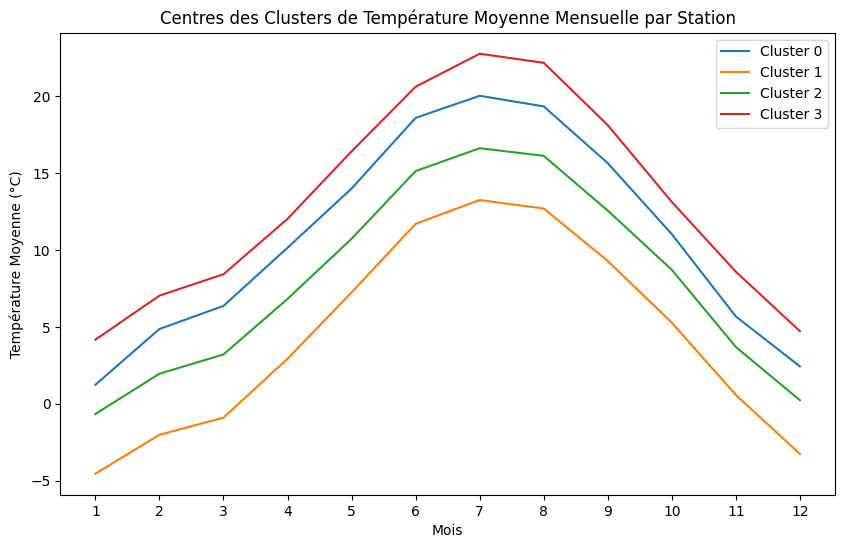

,name,cluster
0,Adelboden,2
1,Altdorf,0
2,Basel / Binningen,0
3,Bern / Zollikofen,0
4,Buchs / Aarau,0
5,Chur,0
6,Davos,1
7,Delémont,0
8,Disentis,2
9,Engelberg,2


In [44]:
combined_chain("cluster temperatures by using tslearn")

In [50]:
combined_chain("What is your temperature prediction for Sion on May 21, 2024?")

2024-05-20 14:12:57,183 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




> Entering new AgentExecutor chain...


2024-05-20 14:12:58,207 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: To make a temperature prediction for Sion on May 21, 2024, we need to filter the dataframe for Sion and the specific date, and then extract the temperature prediction.
Action: python_repl_ast
Action Input: df_sion = df[df['name'] == 'Sion']

2024-05-20 14:13:00,066 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now, let's filter the dataframe for the specific date of May 21, 2024.
Action: python_repl_ast
Action Input: df_sion_may_21_2024 = df_sion[(df_sion['year'] == 2024) & (df_sion['day_of_year'] == 142)]

2024-05-20 14:13:01,770 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Now that we have the specific row for Sion on May 21, 2024, let's extract the temperature prediction.
Action: python_repl_ast
Action Input: temp_prediction = df_sion_may_21_2024['tre200s0'].values[0]IndexError: index 0 is out of bounds for axis 0 with size 0

2024-05-20 14:13:03,124 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


It seems that there is no data for Sion on May 21, 2024 in the dataframe. We should consider looking at a different date or location for a temperature prediction.
Final Answer: There is no temperature prediction available for Sion on May 21, 2024 in the dataframe.

> Finished chain.


{'input': 'What is your temperature prediction for Sion on May 21, 2024?',
 'output': 'There is no temperature prediction available for Sion on May 21, 2024 in the dataframe.'}

2024-05-20 14:10:59,526 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-20 14:11:00,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-20 14:11:20,413 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-05-20 14:11:20,558 - DEBUG - TBB already found in load path
2024-05-20 14:11:20,565 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-05-20 14:11:20,566 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-05-20 14:11:20,579 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\635x1utd.json
2024-05-20 14:11:20,584 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\yq0cb2gl.json
2024-05-20 14:11:20,587 - DEBUG - idx 0
2024-05-20 14:11:20,587 - DEBUG - running CmdStan, num_threads: None
2024-05-20 14:11:20,588 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Deskto

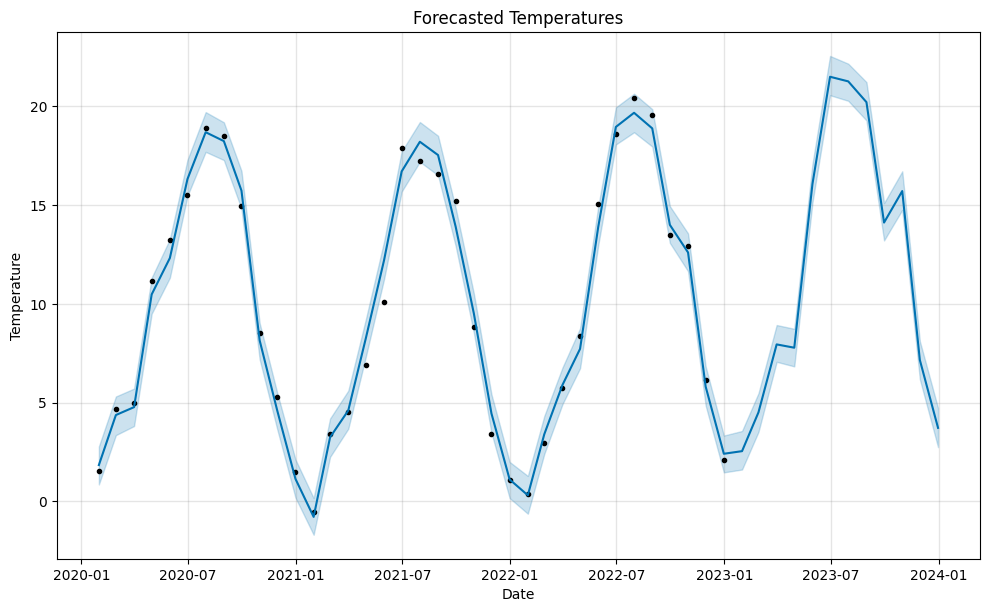

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-31,1.838058,0.854598,2.780657
1,2020-02-29,4.369326,3.352980,5.307865
2,2020-03-31,4.769072,3.812722,5.709194
3,2020-04-30,10.474913,9.497319,11.323441
4,2020-05-31,12.314937,11.320675,13.270537
5,2020-06-30,16.311363,15.462269,17.285149
6,2020-07-31,18.682491,17.688949,19.701278
7,2020-08-31,18.232771,17.271853,19.184555
8,2020-09-30,15.727702,14.808246,16.725249
9,2020-10-31,8.145567,7.188865,9.021974


In [49]:
combined_chain("Predict the daily average temperature for Sion next week")

2024-05-20 14:06:56,120 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-20 14:06:58,474 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-20 14:07:15,310 - DEBUG - cmd: where.exe tbb.dll
cwd: None
2024-05-20 14:07:15,443 - DEBUG - TBB already found in load path
2024-05-20 14:07:15,449 - INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2024-05-20 14:07:15,450 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-05-20 14:07:15,465 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\a4qvaj0j.json
2024-05-20 14:07:15,471 - DEBUG - input tempfile: C:\Users\Abdi\AppData\Local\Temp\tmppdvp_a1o\nre0w0vq.json
2024-05-20 14:07:15,474 - DEBUG - idx 0
2024-05-20 14:07:15,475 - DEBUG - running CmdStan, num_threads: None
2024-05-20 14:07:15,475 - DEBUG - CmdStan args: ['C:\\Users\\Abdi\\Deskto

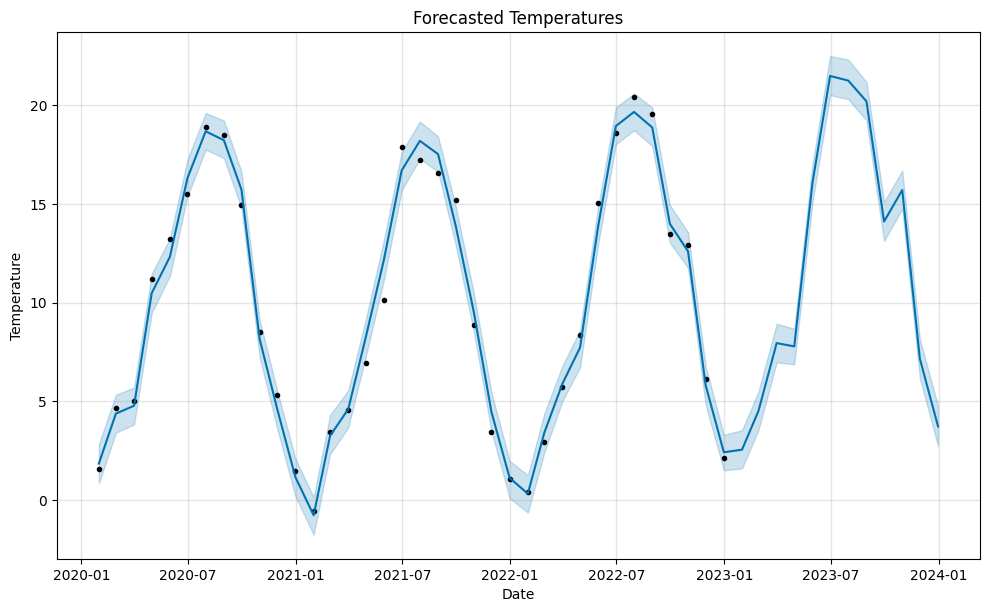

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-31,1.838058,0.828666,2.829454
1,2020-02-29,4.369326,3.405376,5.323588
2,2020-03-31,4.769072,3.818166,5.692263
3,2020-04-30,10.474913,9.469603,11.455716
4,2020-05-31,12.314937,11.344694,13.262410
5,2020-06-30,16.311363,15.395695,17.264067
6,2020-07-31,18.682491,17.753572,19.613392
7,2020-08-31,18.232771,17.325779,19.229758
8,2020-09-30,15.727702,14.792053,16.633510
9,2020-10-31,8.145567,7.218783,9.114795


In [46]:
combined_chain("make weather prediction for Sion for 20 mai 2024,and print it")